# Ensemble Model




## Part 1: Importing Libraries

In [ ]:
!pip install -q keras
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 6.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=ac499d57aefca06eb7429742740a71cf3889bcf0eb711d0aa2367b323e9d48b9
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=98606d4c6efd4a7ff6676b932ad71b69141cc4977cb900889c786281f95d2b0c
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, Concatenate, Input
from keras.models import Model, load_model
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from kerastuner.tuners.bayesian import BayesianOptimization
from tensorflow.keras.applications import *

In [ ]:
print(tf.__version__)


2.3.0


## Part 2: Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Part 3: Dataset Splitting

### Preprocessing

In [ ]:
trainDatagen = ImageDataGenerator(
    rotation_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.20
)

### Training Set

In [ ]:
training_set = trainDatagen.flow_from_directory(
    directory='/content/drive/My Drive/final_dataset_seg_enh_aug/training_set',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=128,
    class_mode="categorical",
    shuffle=True,
    subset='training'
)

### Validation Set

In [ ]:
validation_set = trainDatagen.flow_from_directory(
    directory='/content/drive/My Drive/final_dataset_seg_enh_aug/training_set',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=128,
    class_mode="categorical",
    shuffle=True,
    subset='validation'
)

### Test Set

In [ ]:
test_set = ImageDataGenerator().flow_from_directory(
    directory='/content/drive/My Drive/final_dataset_seg_enh_aug/testing_set',
    target_size=(224, 224),
    shuffle=False
)

Found 600 images belonging to 3 classes.


## Part 3: Building CNN

### Defining Input Layer

In [ ]:
visible = Input(shape=(224,224,3))

### ResNet50

In [ ]:
resnet_model = ResNet50(input_tensor=visible,weights='imagenet',include_top=False)

last_layer = resnet_model.output
x = GlobalAveragePooling2D()(last_layer)

out1 = Flatten()(x)

In [ ]:
for layer in resnet_model.layers:
		layer.trainable = False
		layer._name = 'resnet' + '_' + layer.name

### MobileNet

In [ ]:
mobilenet_model = MobileNetV2(input_tensor=visible,weights='imagenet',include_top=False)

last_layer = mobilenet_model.output
x = GlobalAveragePooling2D()(last_layer)

out2 = Flatten()(x)

In [ ]:
for layer in mobilenet_model.layers:
		layer.trainable = False
		layer._name = 'mobilenet' + '_' + layer.name

### VGG16

In [ ]:
vgg_model = VGG16(input_tensor=visible,weights='imagenet',include_top=False)

last_layer = vgg_model.output
x = GlobalAveragePooling2D()(last_layer)

out3 = Flatten()(x)

In [ ]:
for layer in vgg_model.layers:
		layer.trainable = False
		layer._name = 'vgg' + '_' + layer.name

### Concatenating all the features of ensemble model

In [ ]:
def build_model(hp):

  merge = concatenate([out1, out2, out3])
  x = Dense(hp.Int('d-1', 128, 1024, step=32), activation='relu')(merge)
  x = Dropout(hp.Float('do-1', 0.1, 0.8, step=0.1))(x)
  x = Dense(hp.Int('d-2', 128, 1024, step=32), activation='relu')(x)
  x = Dropout(hp.Float('do-2', 0.1, 0.8, step=0.1))(x)
  output = Dense(3, activation='softmax',name='output_layer')(x)
  model = Model(visible, output)
  
  model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy'])  
  return model

### Applying Bayes Optimization

In [ ]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir_final',
    project_name='model')

In [ ]:
tuner.search(training_set,
             epochs=3,
             validation_data=validation_set)

In [ ]:
model = tuner.get_best_models(1)[0]

### Fitting on Test Set

In [ ]:
filepath="/content/drive/My Drive/models/ensemble/ensemble.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min', save_best_only=True)

In [ ]:
history = model.fit(x = training_set, validation_data = validation_set, epochs = 25, callbacks = [checkpoint])

### Saving the training history

In [ ]:
np.save("/content/drive/My Drive/models/ensemble/ensemble.npy",history.history)

## Part 4: Evaluating the model

In [ ]:
history=np.load("/content/drive/My Drive/models/ensemble/ensemble.npy",allow_pickle='TRUE').item()
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = load_model("/content/drive/My Drive/models/ensemble/ensemble.hdf5")
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
print(classification_report(test_set.classes, y_pred))

Confusion Matrix
[[192   5   3]
 [  0 199   1]
 [  0  16 184]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       200
           1       0.90      0.99      0.95       200
           2       0.98      0.92      0.95       200

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



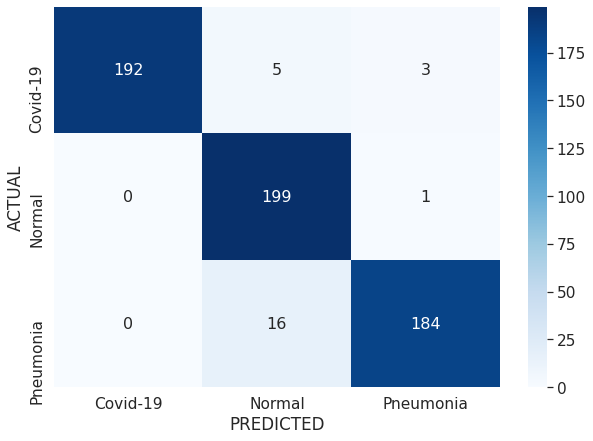

In [ ]:
import pandas as pd
import seaborn as sn
data=confusion_matrix(test_set.classes, y_pred)
class_names = ['Covid-19', 'Normal', 'Pneumonia']
df_cm = pd.DataFrame(data, columns=class_names, index = class_names)
df_cm.index.name = 'ACTUAL'
df_cm.columns.name = 'PREDICTED'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="d")# font size

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


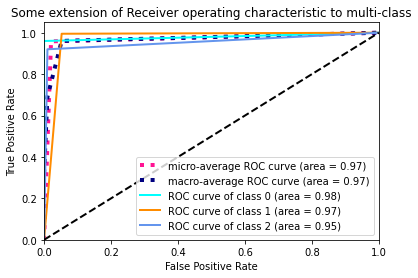

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
n_classes=3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


y_test=test_set.classes
y_test = label_binarize(y_test, classes=[0, 1, 2])
y_pred = label_binarize(y_pred, classes=[0, 1, 2])
n_classes = y_test.shape[1]
print(y_test)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
